# Testing

```source: this key separates the various keys found in the table in Sources. Here's the set of sources with their corresponding value name:```
```
'https://aipulse.org'
'ebook'
'https://qualiacomputing.com'
'alignment forum'
'lesswrong'
'manual'
'arxiv'
'https://deepmindsafetyresearch.medium.com/'
'waitbutwhy.com'
'GitHub'
'https://aiimpacts.org'
'arbital.com'
'carado.moe'
'nonarxiv_papers'
'https://vkrakovna.wordpress.com'
'https://jsteinhardt.wordpress.com'
'audio-transcripts'
'https://intelligence.org'
'youtube'
'reports'
'https://aisafety.camp'
'curriculum'
'https://www.yudkowsky.net'
'distill'
```

```...and this is how the arxiv papers look like:```

```
{
    "source": "arxiv", # where the dataset comes from
    "source_type": "latex", # the type of file the data was original in
    "converted_with": "pandoc", # which tool we used to convert the data in .md format
    "paper_version": paper_id,
    "title": title,
    "authors": [str(x) for x in authors], # list of authors
    "date_published": date_published,
    "data_last_modified": data_last_modified,
    "url": url,
    "abstract": abstract,
    "author_comment": author_comment,
    "journal_ref": journal_ref,
    "doi": doi,
    "primary_category": primary_category,
    "categories": categories,
    "citation_level": citation_level, # (0 = curated alignment papers, 1 = citation of curated papers, 2 = citation of citation, etc.)
    "alignment_text": is_alignment_text, # 'pos' is maunally labeled as an alignment paper, 'unlabeled' if unlabeled
    "confidence_score": confidence_scores, # this is a confidence score obtained by using the SPECTER model to classify papers to add to the dataset
    "main_tex_filename": "main.tex", # the main latex file needed to convert the paper
    "text": "lots of text", # this is where you will grab the text contents of each entry in the dataset (in .md format)
    "bibliography_bbl": "string of bbl",
    "bibliography_bib": "string of bib", # more common to have bib than bbl
}
```

My thoughts are: what's relevant to embed is only the text.

Useful links:

- https://github.com/openai/openai-cookbook/blob/main/examples/Semantic_text_search_using_embeddings.ipynb

- https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb

## Imports

In [202]:
import jsonlines
import numpy as np
from typing import List, Dict, Tuple
import re

import matplotlib.pyplot as plt

## Constants

In [211]:
LEN_EMBEDDINGS = 1536

## Helpers

In [212]:
# FROM https://stackoverflow.com/a/31505798/16185542

# -*- coding: utf-8 -*-
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("?!", "?")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")

    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    
    if sentences == []:
        sentences = [text.strip()]
    return sentences

In [213]:
def split_article(text: str) -> List[str]:
    # Receives one text (str) and returns a list of sections (List[str]), each section being a few appended paragraphs that do not exceed 1000 words.
    # This is done to avoid the 8000 token limit of OpenAI embeddings.
    sections = []
    section = ""
    paragraphs = text.split('\n')
    for paragraph in paragraphs:
        if paragraph == "": continue
        if len(section.split()) + len(paragraph.split()) > 1000 or len(section) + len(paragraph) > 7000:
            sections.append(section)
            section = ""
        section += f"{paragraph}\n"
    sections.append(section)
    return sections

## Dataset Class

In [160]:
"""    
def process_text(self, text: str) -> List[str]:
    # Receives one entry['text'] and returns a list of sections, each section being a few appended paragraphs that do not exceed 5000 words.
    # This is done to avoid the 8000 token limit of OpenAI embeddings.
    sections = []
    section = ""
    for paragraph in text:
        if len(section) + len(paragraph) > 5000:
            sections.append(section)
            section = ""
        section += paragraph
    sections.append(section)
    return sections
"""

'    \ndef process_text(self, text: str) -> List[str]:\n    # Receives one entry[\'text\'] and returns a list of sections, each section being a few appended paragraphs that do not exceed 5000 words.\n    # This is done to avoid the 8000 token limit of OpenAI embeddings.\n    sections = []\n    section = ""\n    for paragraph in text:\n        if len(section) + len(paragraph) > 5000:\n            sections.append(section)\n            section = ""\n        section += paragraph\n    sections.append(section)\n    return sections\n'

In [210]:
class Dataset:
    def __init__(self,
            path: str,  # Path to the dataset .jsonl file.
            sources: List[str] = None,  # List of sources to include. If None, include all sources.
            max_paragraph_length: Tuple[int, int] = None,  # (max number of words in a paragraph, max number of characters in a paragraph)
            load_data: bool = False,  # Whether to load the data from the .jsonl file at initialization.
            load_embeddings: bool = False,  # Whether to load the embeddings from the .npy file at initialization. (only available if load_data is True)
        ):
        self.path = path
        self.sources = sources
        self.max_paragraph_length = max_paragraph_length
            
        self.data: List[Tuple[str, str, str]] = []  # List of tuples, each containing the title of an article, its URL, and text. E.g.: [('title', 'url', 'text'), ...]
        self.embed_split: List[str] = []  # List of strings, each being a few paragraphs from a single article (not exceeding 1000 words).
        
        self.num_articles: Dict[str, int] = {}  # Number of articles per source. E.g.: {'source1': 10, 'source2': 20, 'total': 30}
        if sources is None:
            continue
        else:
            for source in sources: self.num_articles[source] = 0
        self.num_articles['total'] = 0
        
        self.total_char_count = 0
        self.total_word_count = 0
        self.total_sentence_count = 0
        self.total_paragraph_count = 0
        
        if load_data:
            self.load()
            if load_embeddings:
                self.load_embeddings()
    
    def load(self):
        with jsonlines.open(self.path, "r") as reader:
            for entry in reader:
                try:
                    if self.sources is None:
                        if entry['source'] not in self.num_articles:
                            self.num_articles[entry['source']] = 1
                        else:
                            self.num_articles[entry['source']] += 1
                        self.num_articles['total'] += 1
                    else:
                        if entry['source'] in self.sources:
                            self.num_articles[entry['source']] += 1
                            self.num_articles['total'] += 1
                        else:
                            continue
                    
                    self.data.append((entry['title'], entry['url'], entry['text']))
                    paragraphs = split_article(entry['text'])
                    self.embed_split.extend(paragraphs)
                    
                    self.total_char_count += len(entry['text'])
                    self.total_word_count += len(entry['text'].split())
                    self.total_sentence_count += len(split_into_sentences(entry['text']))
                    self.total_paragraph_count += len(paragraphs)
                except KeyError:
                    print(f"KeyError: {entry['url']}")
        
    def load_embeddings(self):
        raise NotImplementedError

SyntaxError: 'continue' not properly in loop (3525560596.py, line 17)

In [195]:
alignment_dataset = r"C:\Users\Henri\Documents\GitHub\AlignmentSearch\data\alignment_texts.jsonl"

worthwhile_sources = [
    'https://aipulse.org',
    'ebook',
    'https://qualiacomputing.com',
    'alignment forum',
    'lesswrong',
    'manual',
    'arxiv',
    'https://deepmindsafetyresearch.medium.com/',
    'waitbutwhy.com',
    'GitHub',
    'https://aiimpacts.org',
    'arbital.com',
    'carado.moe',
    'nonarxiv_papers',
    'https://vkrakovna.wordpress.com',
    'https://jsteinhardt.wordpress.com',
    'audio-transcripts',
    'https://intelligence.org',
    'youtube',
    'reports',
    'https://aisafety.camp',
    'curriculum',
    'https://www.yudkowsky.net',
    'distill'
]

In [184]:
dataset = Dataset(path=alignment_dataset, sources=worthwhile_sources)
dataset.load()

In [207]:
len_embeds = []
for embed in dataset.embed_split:
    len_embeds.append(len(embed.split()))
print(max(len_embeds))

12502


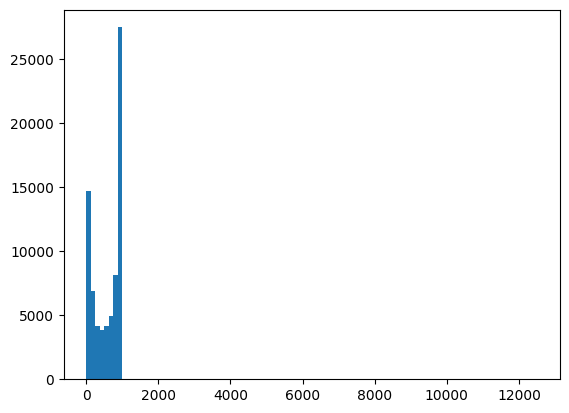

In [208]:
# Plot the number of characters per embedding
plt.hist([len(embed.split()) for embed in dataset.embed_split], bins=100)
plt.savefig("embed_char_count.png")

In [193]:
# self.path = path
# self.sources = sources
# self.max_data_length = max_data_length
# self.len_embeddings = len_embeddings


# self.data: List[Tuple[str, str, str]] = []  # List of tuples, each containing the title of an article, its URL, and text. E.g.: [('title', 'url', 'text'), ...]
# self.embed_split: List[str] = []  # List of strings, each being a few paragraphs from a single article (not exceeding 1000 words).

# self.num_articles: Dict[str, int] = {}  # Dict of number of articles from each source, with total number of articles. Initialize num_articles to 0 for each source.
# for source in sources: self.num_articles[source] = 0
# self.num_articles['total'] = 0

# self.total_char_count = 0
# self.total_word_count = 0
# self.total_sentence_count = 0
# self.total_paragraph_count = 0

num_articles_truth = {
    'https://aipulse.org': 23,
    'ebook': 23,
    'https://qualiacomputing.com': 278,
    'alignment forum': 2138,
    'lesswrong': 28252, # +227?
    'manual': 132, # Stampy.ai?
    'arxiv': 707 + 1679 + 1000 + 4621,
    'https://deepmindsafetyresearch.medium.com/': 10,
    'waitbutwhy.com': 2,
    'GitHub': 0, # Huh?
    'https://aiimpacts.org': 227,
    'arbital.com': 223,
    'carado.moe': 59,
    'nonarxiv_papers': 323,
    'https://vkrakovna.wordpress.com': 43,
    'https://jsteinhardt.wordpress.com': 39,
    'audio-transcripts': 25,
    'https://intelligence.org': 479,
    'youtube': 457,
    'reports': 323,
    'https://aisafety.camp': 8,
    'curriculum': 0, # Huh?
    'https://www.yudkowsky.net': 23,
    'distill': 49,
    'total': 2138+28252+707+1679+1000+4621+23+227+23+8+59+111+10+17+7+479+39+278+43+2+23+420+323+49+457+25+12+223+227+132    
}
word_count_truth = 53_550_146
char_count_truth = 351_767_163

# Print table. First row has Truth and Empirical findings.
print(f"{'Source':<20} {'Truth':<10} {'Empirical':<10}")
for source in dataset.num_articles:
    print(f"{source[:20]:<20} {num_articles_truth[source]:<10} {dataset.num_articles[source]:<10}")

Source               Truth      Empirical 
https://aipulse.org  23         23        
ebook                23         22        
https://qualiacomput 278        278       
alignment forum      2138       2138      
lesswrong            28252      28259     
manual               132        1         
arxiv                8007       7012      
https://deepmindsafe 10         10        
waitbutwhy.com       2          2         
GitHub               0          1         
https://aiimpacts.or 227        227       
arbital.com          223        223       
carado.moe           59         59        
nonarxiv_papers      323        244       
https://vkrakovna.wo 43         43        
https://jsteinhardt. 39         39        
audio-transcripts    25         37        
https://intelligence 479        479       
youtube              457        457       
reports              323        78        
https://aisafety.cam 8          8         
curriculum           0          1         
https://www

In [150]:

num_words = dataset.data_length / 5
num_tokens = num_words * 1.5
num_paragraphs = num_words // 200
num_embeds_method_1 = num_tokens // 8096
num_embeds_method_2 = num_words // 600
cost_per_embed = 1/(3000*500/8096)
cost_per_page = 1/3000
num_pages = num_words // 500
cost_1 = num_pages * cost_per_page
cost_2 = num_embeds_method_2 * cost_per_embed

print(f"{dataset.data_length} characters")
print(f"~{num_tokens:.0f} tokens")
print(f"~{num_words:.0f} words")
print(f"~{num_paragraphs:.0f} paragraphs")
print(f"~{num_embeds_method_1:.0f} embeddings using method 1")
print(f"~{num_embeds_method_2:.0f} embeddings using method 2")
print(f"~{num_pages:.0f} pages")
print(f"~{cost_1:.0f} cost using method 1")
print(f"~{cost_2:.0f} cost using method 2")

348457759 characters
~104537328 tokens
~69691552 words
~348457 paragraphs
~12912 embeddings using method 1
~116152 embeddings using method 2
~139383 pages
~46 cost using method 1
~627 cost using method 2


In [143]:
3000*500/8000

187.5

In [ ]:
# 1$ per 2000 embeds

In [37]:
import numpy as np

In [39]:
# Make a 1D array of 1536 (very small) random numbers which add up to 1, and a 2D array of shape (1536, 100000), and for each row the sum of the elements is 1.
arr1 = np.random.rand(1536)
arr1 /= arr1.sum()

arr2 = np.random.rand(1536, 100000)
arr2 /= arr2.sum(axis=0)

In [41]:
# Now, calculate the amount of time it takes to take the dot product of the two arrays.
%timeit arr1.dot(arr2)

67.8 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
arr3 = arr1.dot(arr2)

In [61]:
arr3.shape

(100000,)

In [60]:
# top k argmax
k = 10
top_k = np.argmax(arr3, axis=0)[:k]

IndexError: invalid index to scalar variable.

In [66]:
import openai
import config

In [67]:
EMBEDDING_MODEL = "text-embedding-ada-002"
openai.api_key = config.OPENAI_API_KEY

In [129]:
def random_unit_vectors(d, n):
    vec = np.random.randn(d, n)
    norm = np.linalg.norm(vec, axis=0)
    return vec / norm


In [133]:
d = 1536
n = 1000
rand_mat = random_unit_vectors(d, n)

In [134]:
rand_mat.shape

(1536, 1000)

In [73]:
def get_embedding(text: str, model: str=EMBEDDING_MODEL) -> list[float]:
    result = openai.Embedding.create(
      model=model,
      input=text
    )
    return np.array(result["data"][0]["embedding"])

In [103]:
a = get_embedding("JSON stands for JavaScript Object Notation. It means that a script (executable) file which is made of text in a programming language, is used to store and transfer the data. Python supports JSON through a built-in package called json. To use this feature, we import the json package in Python script. The text in JSON is done through quoted-string which contains value in key-value mapping within { }. It is similar to the dictionary in Python.")

In [108]:
arr2.shape

(1536, 100000)

In [107]:
# Find the distance of a to origin
np.linalg.norm(arr2, axis=0)

array([0.02933221, 0.02961996, 0.02955815, ..., 0.02957929, 0.02946535,
       0.02934775])

In [97]:
%timeit a.dot(arr2)

77 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
# %timeit np.argmax(a.dot(arr2)

array([0.00081222])

In [98]:
b = a.dot(arr2)

In [102]:
b[b<0].shape

(97841,)